# Outlier removal

In this notebook, I cover the basics of removing outliers using the `grubbs` test. The dataset used is the famous crime dataset from the UCI repository http://www.statsci.org/data/general/uscrime.txt data dictionary available at http://www.statsci.org/data/general/uscrime.html.



### Load library and set seed



In [4]:
# install.packages('outliers')
library(outliers)
library("IRdisplay")
require(outliers)
set.seed(37)



### Load data and check head



In [2]:
data <- read.table("uscrime.txt", header=T)

In [3]:
head(data)

M,So,Ed,Po1,Po2,LF,M.F,Pop,NW,U1,U2,Wealth,Ineq,Prob,Time,Crime
15.1,1,9.1,5.8,5.6,0.510,95.0,33,30.1,0.108,4.1,3940,26.1,0.084602,26.2011,791
14.3,0,11.3,10.3,9.5,0.583,101.2,13,10.2,0.096,3.6,5570,19.4,0.029599,25.2999,1635
14.2,1,8.9,4.5,4.4,0.533,96.9,18,21.9,0.094,3.3,3180,25.0,0.083401,24.3006,578
13.6,0,12.1,14.9,14.1,0.577,99.4,157,8.0,0.102,3.9,6730,16.7,0.015801,29.9012,1969
14.1,0,12.1,10.9,10.1,0.591,98.5,18,3.0,0.091,2.0,5780,17.4,0.041399,21.2998,1234
12.1,0,11.0,11.8,11.5,0.547,96.4,25,4.4,0.084,2.9,6890,12.6,0.034201,20.9995,682




### Check length of crime rate vector

Let's check the initial length of the crime rate per 100,000 people vector present in the raw data. This will tell us how many observations our data initially has. After running the grubbs test we can definitively see how many data points were considered "outliers" and were removed from our raw data.



In [4]:
raw_data_length <- length(data$Crime)
raw_data_length

[1] 47



### Plot raw data

On the plot I've highlighted the min and max points in red.



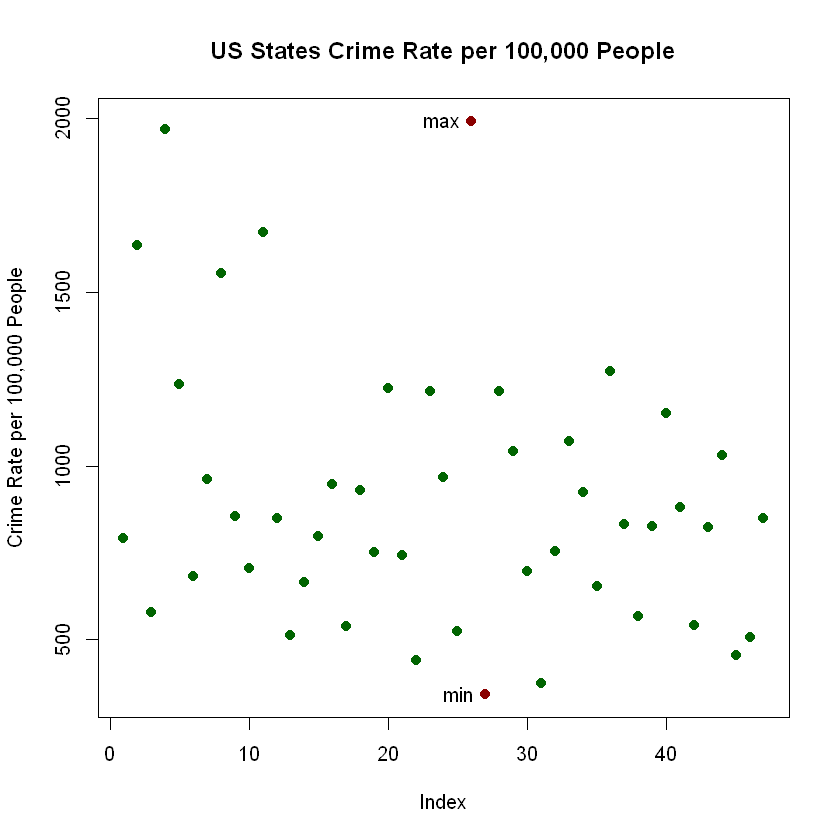

In [5]:
plot(data$Crime, 
    main="US States Crime Rate per 100,000 People",
    ylab="Crime Rate per 100,000 People",
    pch=20, cex=1.7,
    col=ifelse(data$Crime==min(data$Crime) |
               data$Crime==max(data$Crime),
              "darkred","darkgreen"))
text(which(data$Crime==min(data$Crime)),
     min(data$Crime),labels="min",pos=2)
text(which(data$Crime==max(data$Crime)),
     max(data$Crime),labels="max",pos=2)

In [6]:
min(data$Crime)

[1] 342

In [7]:
max(data$Crime)

[1] 1993



### Boxplot raw data



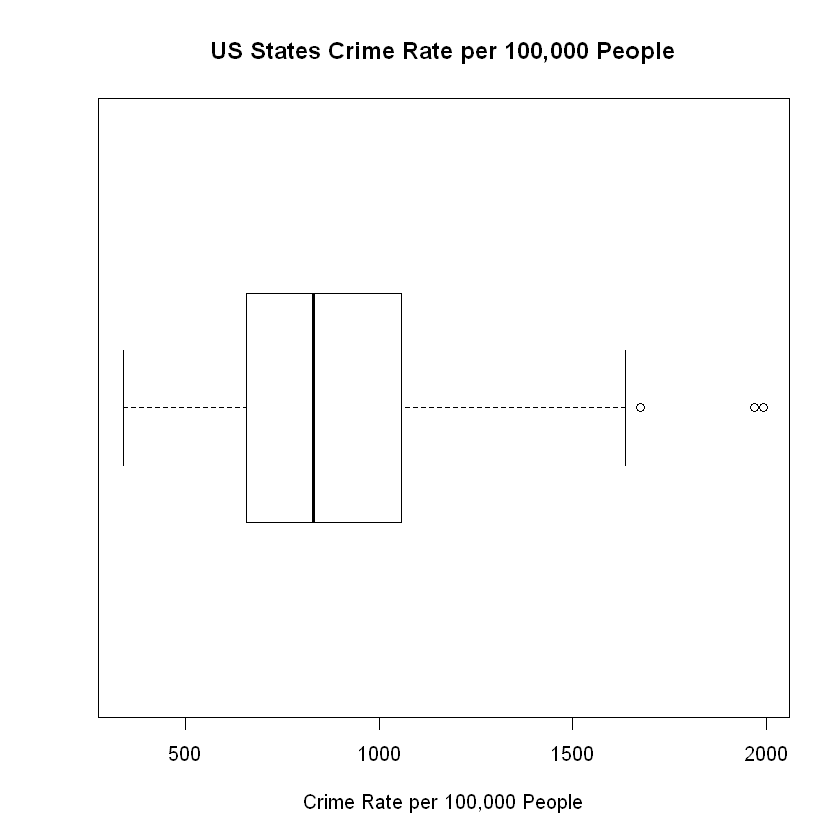

In [8]:
# reference: https://www.rdocumentation.org/packages/graphics/versions/3.4.3/topics/boxplot

boxplot(data$Crime, horizontal = T,
        xlab="Crime Rate per 100,000 People",
        main="US States Crime Rate per 100,000 People")



### Histogram raw data

On the histogram I have added two lines (one for the mean and one for the median). This will tell us if the raw data is skewed one way or another. A key assumption to using the Grubbs test is that the input data is normally distributed. Plotting the data in histogram form will give us a quick visual check of the normality present in our input dataset.



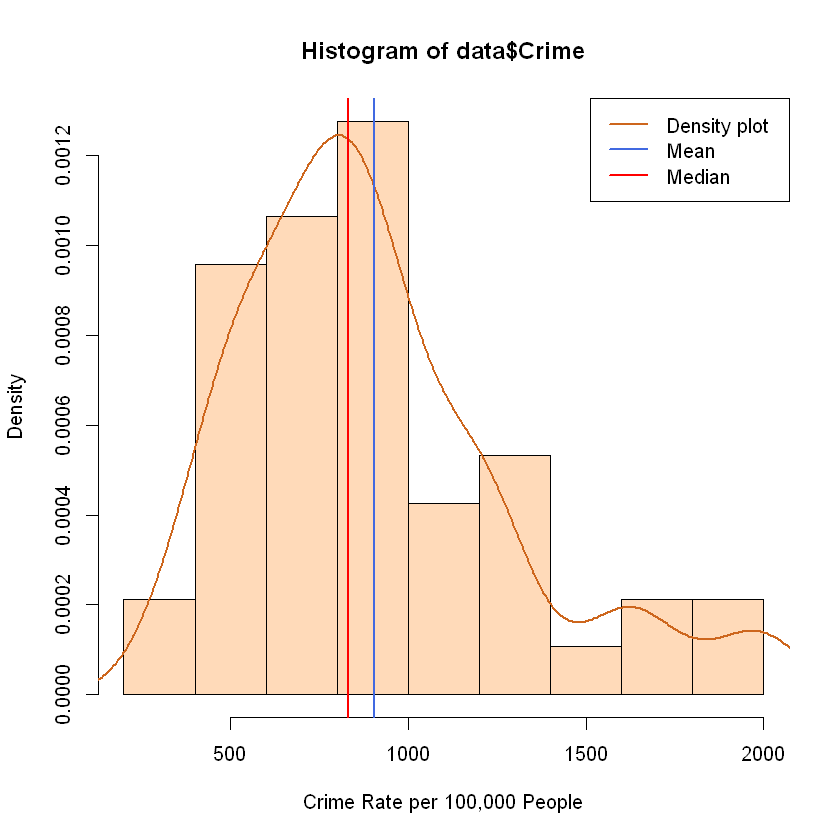

In [9]:
# reference: https://www.r-bloggers.com/adding-measures-of-central-tendency-to-histograms-in-r/

hist(data$Crime, probability = T,
     col = "peachpuff",
     xlab="Crime Rate per 100,000 People")
lines(density(data$Crime), # density plot
 lwd = 2, # thickness of line
 col = "chocolate3")
abline(v = mean(data$Crime),
 col = "royalblue",
 lwd = 2)
abline(v = median(data$Crime),
 col = "red",
 lwd = 2)
legend(x = "topright", # location of legend within plot area
 c("Density plot", "Mean", "Median"),
 col = c("chocolate3", "royalblue", "red"),
 lwd = c(2, 2, 2))



As we can see from the histogram above, the raw data is clearly normally distributed, but skewed towards higher crime rates per capita (mean value is greater than the median value). See excellent reference below:

http://davidmlane.com/hyperstat/A92403.html



In [10]:
raw_skew_measure <- mean(data$Crime) - median(data$Crime)
raw_skew_measure

[1] 74.08511



### Q-Q plot raw data

A Q-Q plot tests our input data for normality. If the data is normally distributed, we should be able to draw a line through all the data points that intercepts at the origin.



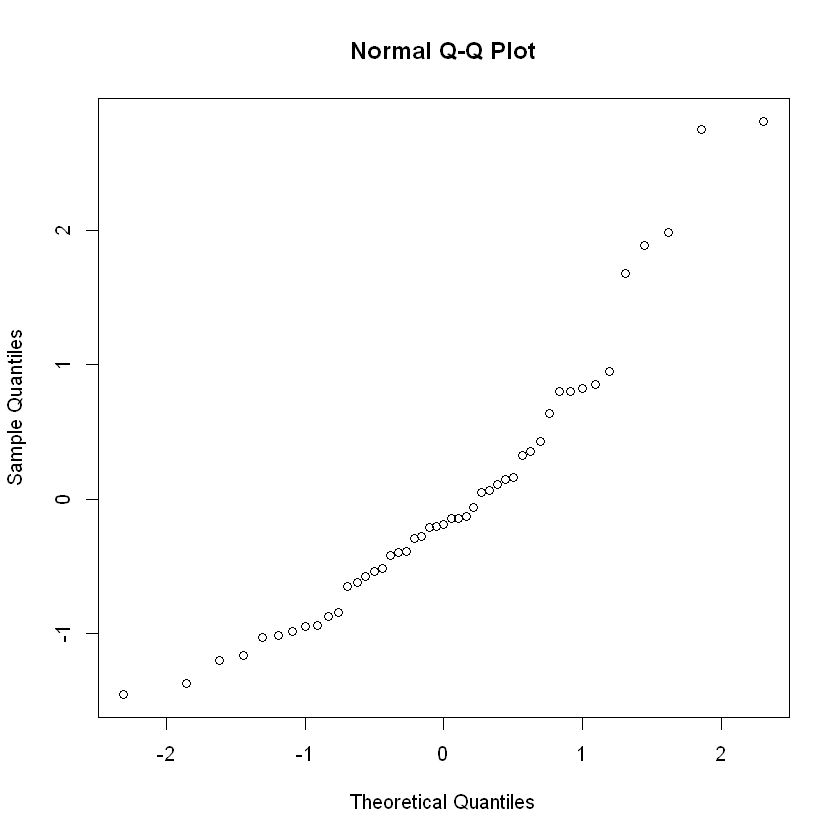

In [11]:
qqnorm(scale(data$Crime))



While not perfectly normally distributed (the tail at the high end is skewing our data), we can tell from the histogram and the Q-Q plot above that our data passes the normality test. We may proceed with the Grubbs test!





### Recursively eliminate outliers

The recursive function below works in the following way:

* Grubbs test is performed on the input vector (type=10 - only testing for one outlier)
    * Testing occurs at both ends of the tails
* If the p-value returned by Grubbs test is below a user defined threshold (alpha), the following steps occur:
    * The outlier returned by Grubbs test is identified using regex
    * The outlier returned by Grubbs test is removed from the vector
    * A function call is made back to the Grubbs test with overwritten vector
* Else if p-value is above threshold alpha, the function returns the last vector created



In [12]:
# reference: http://stackoverflow.com/a/24397936
# reference: http://www.regular-expressions.info/rlanguage.html
# reference: http://regex101.com/
# reference: http://stackoverflow.com/q/9665984

eliminate_outliers_grubbs_test <- function(vector, alpha){
    grubbs_test <- grubbs.test(vector, type = 10)
    if (grubbs_test$p.value <= alpha) {
        m <- regexpr("(\\d+)", grubbs_test$alternative, perl=TRUE)
        val_to_remove <- as.numeric(regmatches(grubbs_test$alternative, m))
        remove <- c(val_to_remove)
        vector <- vector[!vector %in% remove]
        eliminate_outliers_grubbs_test(vector, alpha)
    } else{
        return(vector)
    }
}



### eliminate_outliers_grubbs_test with 0.1 p-value threshold (alpha)



In [13]:
crime_outliers_removed.1 <- eliminate_outliers_grubbs_test(data$Crime,
                                                         0.1)



### Check difference between length of raw data and length of returned vector

This will tell us how many outliers the Grubbs test found/removed from the input vector.



In [14]:
crime_outliers_removed.1_length <- length(crime_outliers_removed.1)
raw_data_length - crime_outliers_removed.1_length

[1] 2



Grubbs test found/removed two outliers with returned p-value less than or equal to alpha=0.1.





### Scatterplot vector with outliers removed



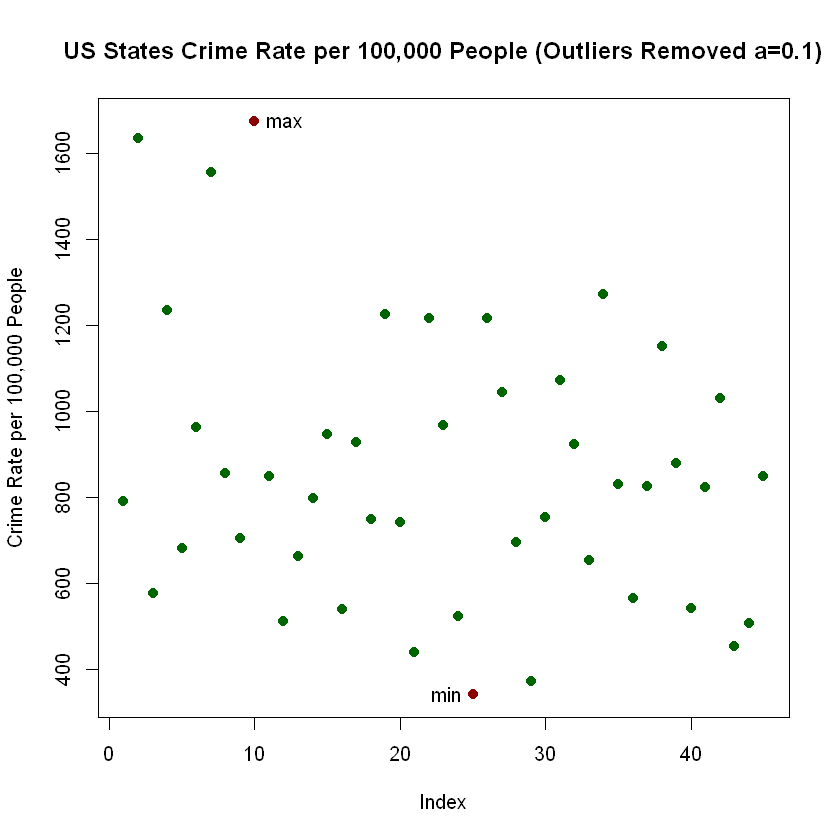

In [32]:
plot(crime_outliers_removed.1, 
    main="US States Crime Rate per 100,000 People (Outliers Removed a=0.1)",
    ylab="Crime Rate per 100,000 People",
    pch=20, cex=1.7,
    col=ifelse(crime_outliers_removed.1==min(crime_outliers_removed.1) |
               crime_outliers_removed.1==max(crime_outliers_removed.1),
              "darkred","darkgreen"))
text(which(crime_outliers_removed.1==min(crime_outliers_removed.1)),
     min(crime_outliers_removed.1),labels="min",pos=2)
text(which(crime_outliers_removed.1==max(crime_outliers_removed.1)),
     max(crime_outliers_removed.1),labels="max",pos=4)

In [16]:
min(crime_outliers_removed.1)

[1] 342

In [17]:
max(crime_outliers_removed.1)

[1] 1674



### Boxplot vector with outliers removed



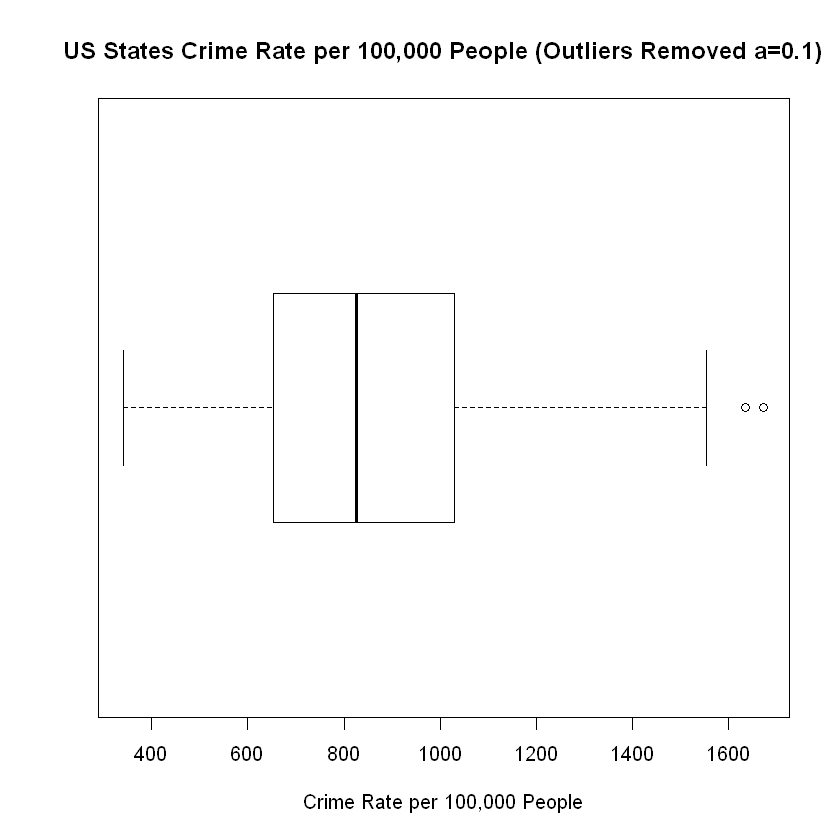

In [31]:
# reference: https://www.rdocumentation.org/packages/graphics/versions/3.4.3/topics/boxplot

boxplot(crime_outliers_removed.1, horizontal = T,
        xlab="Crime Rate per 100,000 People",
        main="US States Crime Rate per 100,000 People (Outliers Removed a=0.1)")



### Histogram vector with outliers removed

On the histogram I have added two lines (one for the mean and one for the median). This will tell us if the transformed data is still skewed one way or another.



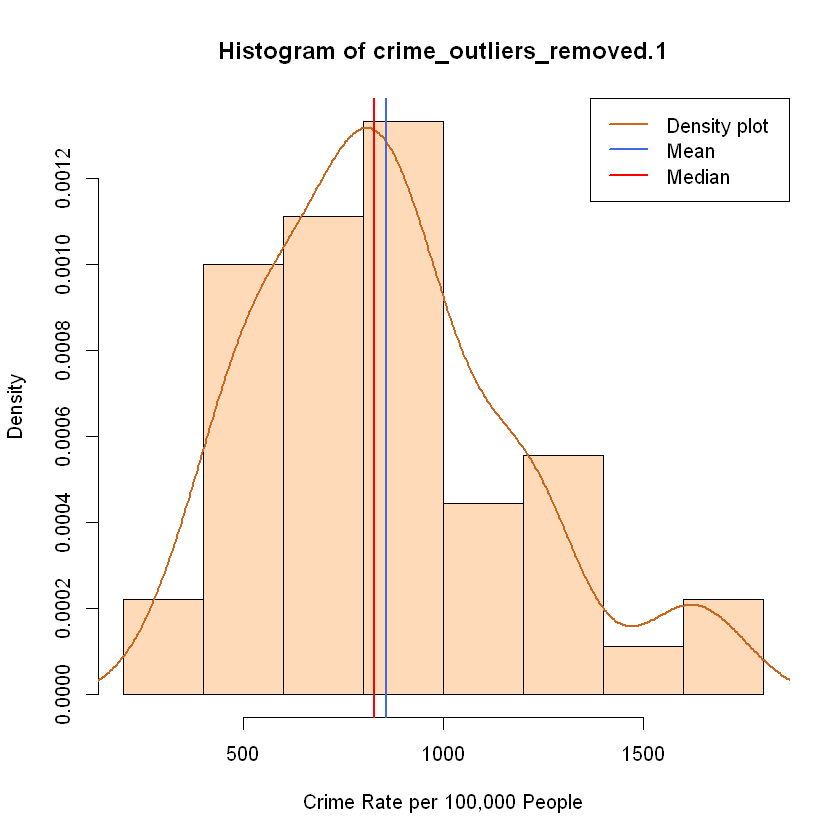

In [19]:
# reference: https://www.r-bloggers.com/adding-measures-of-central-tendency-to-histograms-in-r/

hist(crime_outliers_removed.1, probability = T,
     col = "peachpuff",
     xlab="Crime Rate per 100,000 People")
lines(density(crime_outliers_removed.1), # density plot
 lwd = 2, # thickness of line
 col = "chocolate3")
abline(v = mean(crime_outliers_removed.1),
 col = "royalblue",
 lwd = 2)
abline(v = median(crime_outliers_removed.1),
 col = "red",
 lwd = 2)
legend(x = "topright", # location of legend within plot area
 c("Density plot", "Mean", "Median"),
 col = c("chocolate3", "royalblue", "red"),
 lwd = c(2, 2, 2))

In [20]:
transformed_skew_measure <- mean(crime_outliers_removed.1) - 
                            median(crime_outliers_removed.1)
transformed_skew_measure

[1] 31.26667

In [21]:
transformed_skew_measure < raw_skew_measure

[1] TRUE



As we can see from the histogram/calculations above, the large positive skew present in the raw data has been drastically reduced, just by removing the two high-end outliers.





### Explicit comparison


Let's compare explicitly which values were removed from the raw data after running it through our recursive Grubbs Test function with 0.1 p-value threshold (alpha).



In [22]:
# reference: https://stackoverflow.com/a/3695700
# reference: https://stackoverflow.com/a/14949751

union_raw_transformed.1 <- intersect(data$Crime,
                                     crime_outliers_removed.1)
removed_from_raw.1 <- setdiff(data$Crime,
                              crime_outliers_removed.1)

In [23]:
union_raw_transformed.1

[1]  791 1635  578 1234  682  963 1555  856  705 1674  849  511  664  798  946
[16]  539  929  750 1225  742  439 1216  968  523  342 1043  696  373  754 1072
[31]  923  653 1272  831  566  826 1151  880  542  823 1030  455  508

In [24]:
removed_from_raw.1

[1] 1969 1993



### Sanity check

As a built-in sanity check, let's see if the minimum point in our dataset is also an outlier as Grubbs seems to only be considering the high-end crime rates.



In [25]:
grubbs.test(data$Crime, type = 10, opposite = TRUE)


	Grubbs test for one outlier

data:  data$Crime
G = 1.45590, U = 0.95292, p-value = 1
alternative hypothesis: lowest value 342 is an outlier




The city with the lowest crime rate is ***NOT*** an outlier according to Grubbs test with alpha set to 0.1. The two cities with the highest crime rates ***ARE*** considered outliers according to Grubbs test with alpha set to 0.1.





### Testing at alpha=0.05

Now let's repeat the test with a p-value threshold (alpha) set to 0.05. We should expect fewer points to be removed from the input dataset because we are defining a higher significance threshold for outlier removal.



In [26]:
crime_outliers_removed.05 <- eliminate_outliers_grubbs_test(data$Crime,
                                                         0.05)



### Check length of returned vector

This will tell us how many outliers the Grubbs test found/removed from the input vector.



In [27]:
crime_outliers_removed.05_length <- length(crime_outliers_removed.05)
raw_data_length - crime_outliers_removed.05_length

[1] 0



Grubbs test found/removed zero outliers with returned p-value less than or equal to initial alpha = 0.05.





### Sanity check

Let's run the Grubbs test and observe the returned p-value directly as a sanity check to the recursive function employed above.



In [28]:
grubbs.test(data$Crime, type = 10)


	Grubbs test for one outlier

data:  data$Crime
G = 2.81290, U = 0.82426, p-value = 0.07887
alternative hypothesis: highest value 1993 is an outlier




There you have it! Outliers were only removed from the dataset with an initial alpha set to 0.1.

